In [ ]:
zip_file_path = '/dataset.zip'
!unzip -q '{zip_file_path}' -d '/bmi'

In [ ]:
import os

input_folder = "/bmi/front/front"

file_list = os.listdir(input_folder)

for file_name in file_list:
    old_path = os.path.join(input_folder, file_name)
    new_name = f"{os.path.splitext(file_name)[0]}.jpg"
    new_path = os.path.join(input_folder, new_name)

    try:
        os.rename(old_path, new_path)
    except Exception as e:
        print(f"Error renaming {file_name}: {e}")


In [ ]:
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from google.colab.patches import cv2_imshow
import tensorflow as tf

In [ ]:
csv_file_path = '/bmi/label.csv'
data = pd.read_csv(csv_file_path)
data.head()

,ID,Sex,Height,Weight,feet,inches,height,weight,bmi
0,A00147,Male,5 ft. 07 in.,185 lbs.,5,7,67,185,28.97
1,A00198,Male,6 ft. 02 in.,190 lbs.,6,2,74,190,24.39
2,A00360,Male,5 ft. 09 in.,167 lbs.,5,9,69,167,24.66
3,A00367,Male,6 ft. 00 in.,245 lbs.,6,0,72,245,33.22
4,A01054,Male,5 ft. 07 in.,166 lbs.,5,7,67,166,26.00


In [ ]:
data['image_path'] = "/bmi/front/front/" + data['ID'] + ".jpg"

In [ ]:
data = data[data['bmi'] != '#VALUE!']
data['bmi'] = data['bmi'].astype(float)

<ipython-input-8-51756a35a552>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['bmi'] = data['bmi'].astype(float)


In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
data.head()

,ID,Sex,Height,Weight,feet,inches,height,weight,bmi,image_path
0,M47396,Male,6 ft. 10 in.,263 lbs.,6,10,82,263,27.50,/content/bmi/front/front/M47396.jpg
1,S01333,Male,5 ft. 08 in.,179 lbs.,5,8,68,179,27.21,/content/bmi/front/front/S01333.jpg
2,M44307,Male,5 ft. 08 in.,200 lbs.,5,8,68,200,30.41,/content/bmi/front/front/M44307.jpg
3,M36155,Male,6 ft. 01 in.,225 lbs.,6,1,73,225,29.68,/content/bmi/front/front/M36155.jpg
4,B37084,Male,6 ft. 00 in.,217 lbs.,6,0,72,217,29.43,/content/bmi/front/front/B37084.jpg


In [ ]:
train_ratio = 0.8
train_size = int(train_ratio * len(data))
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:]

In [ ]:
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,          # Normalize the pixel values between 0 and 1
)

In [ ]:
train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='bmi',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
)
val_generator = datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='image_path',
    y_col='bmi',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
)

Found 55725 validated image filenames.
Found 13932 validated image filenames.


In [ ]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator
)



Epoch 1/5
1742/1742 [==============================] - 1246s 713ms/step - loss: 27.1248 - val_loss: 23.8359
Epoch 2/5
1742/1742 [==============================] - 1221s 701ms/step - loss: 24.1635 - val_loss: 26.7036
Epoch 3/5
1742/1742 [==============================] - 1202s 690ms/step - loss: 23.6894 - val_loss: 22.6549
Epoch 4/5
1742/1742 [==============================] - 1246s 715ms/step - loss: 23.0349 - val_loss: 26.0082
Epoch 5/5
1742/1742 [==============================] - 1249s 717ms/step - loss: 22.6828 - val_loss: 23.0450


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
val_loss = model.evaluate(val_generator)

436/436 [==============================] - 248s 569ms/step - loss: 23.2195


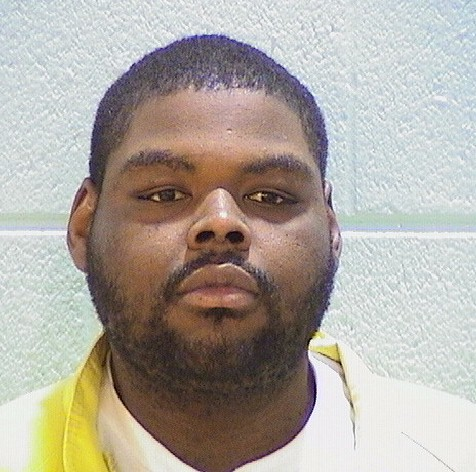

In [ ]:
x = cv2.imread("/bmi/front/front/M47396.jpg")
cv2_imshow(x)

In [ ]:
import cv2
import numpy as np

input_shape = (224, 224)
resized_image = cv2.resize(x, input_shape, interpolation=cv2.INTER_AREA)

resized_image_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

resized_image_normalized = resized_image_rgb.astype('float32') / 255.0

input_image = np.expand_dims(resized_image_normalized, axis=0)

#input_image has the shape (1, 224, 224, 3) with the amount of images in batch that is 1.
predictions = model.predict(input_image)


1/1 [==============================] - 0s 28ms/step


In [ ]:
print(predictions)

[[32.277565]]


In [ ]:
model_path = '/model.tflite'

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input details:", input_details)
print("Output details:", output_details)


Input details: [{'name': 'serving_default_input_6:0', 'index': 0, 'shape': array([  1, 224, 224,   3], dtype=int32), 'shape_signature': array([ -1, 224, 224,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'StatefulPartitionedCall:0', 'index': 179, 'shape': array([1, 1], dtype=int32), 'shape_signature': array([-1,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


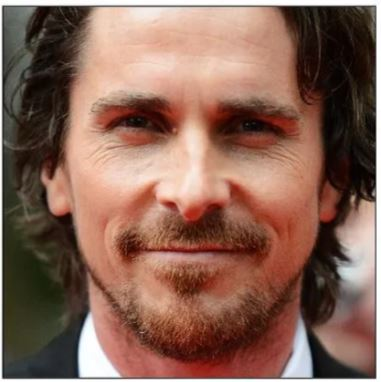

[[24.009108]]


In [ ]:
y = cv2.imread("/content/Capture.JPG")
image = cv2.resize(y, (224, 224))  
image = image.astype(np.float32) / 255.0  
image = np.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], image)

interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])

cv2_imshow(y)
print(output_data)


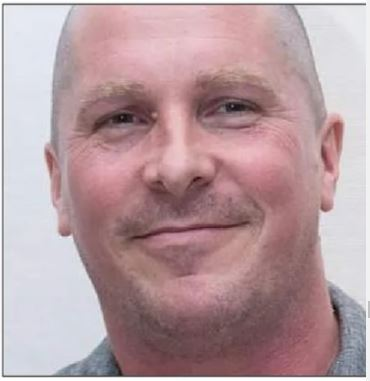

[[35.94564]]


In [ ]:
y = cv2.imread("/content/Capture2.JPG")
image = cv2.resize(y, (224, 224))  # Resize the image to match the model input shape
image = image.astype(np.float32) / 255.0  # Normalize pixel values to [0, 1]
image = np.expand_dims(image, axis=0)

interpreter.set_tensor(input_details[0]['index'], image)

# Run inference
interpreter.invoke()

# Get the output data from the model
output_data = interpreter.get_tensor(output_details[0]['index'])

cv2_imshow(y)
print(output_data)
